In [1]:
import numpy as np
import cv2

import torch
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

In [2]:
from PIL import Image

In [3]:
import os

In [4]:
import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [6]:
# def createDeepLabv3(outputchannels=1):
#     model = models.segmentation.deeplabv3_resnet101(
#         pretrained=True, progress=True)
#     model.classifier = DeepLabHead(2048, outputchannels)
#     model.train()
#     return model
  
# model = createDeepLabv3(outputchannels=1).to(device)

In [7]:
model = torch.load("/home/andresokol/deeplab_weights_2022-05-07T21 08 10.063685.pt")

In [8]:
FFHQ_DIR = "/home/andresokol/data/compressed"

class InferenceImageDataset(Dataset):
    transform = transforms.Compose([
        transforms.Resize((256, 256), transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    def __init__(self, mode="train"):
        self.paths = []
        for dirname in os.listdir(FFHQ_DIR):
            if not os.path.exists(f"/home/andresokol/data/masks/{dirname}"):
                os.mkdir(f"/home/andresokol/data/masks/{dirname}")
            for filename in os.listdir(f"{FFHQ_DIR}/{dirname}"):
                if filename[:5].isdigit() and filename[5:] == ".jpg":
                    self.paths.append(f"{dirname}/{filename}")

    def __getitem__(self, index):
        image_path = self.paths[index % len(self)]
        source_img = Image.open(f"{FFHQ_DIR}/{image_path}")
        return self.transform(source_img), image_path

    def __len__(self):
        return len(self.paths)

In [9]:
dataloader = DataLoader(
    InferenceImageDataset(),
    batch_size=16,
    num_workers=2,
)

In [10]:
def save_image(pred, path):
    grayscale = (pred > 0.5).transpose(1,2,0).astype("uint8") * 255
    Image.fromarray(np.dstack([grayscale] * 3)).save(f"/home/andresokol/data/masks/{path}")

In [11]:
model.eval()

for batch in tqdm.auto.tqdm(dataloader):
    images, paths = batch
    images = images.to(device)
    masks = model(images)
    masks = masks["out"].cpu().detach().numpy()
    
    for i in range(len(paths)):
        save_image(masks[i], paths[i])

  0%|          | 0/1256 [00:00<?, ?it/s]

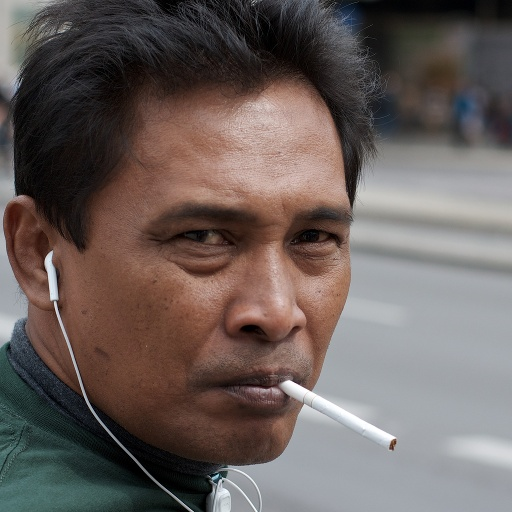

In [25]:
Image.open("/home/andresokol/data/compressed/09000/09014.jpg")

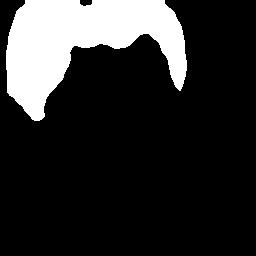

In [26]:
Image.open("/home/andresokol/data/masks/09000/09014.jpg")